# Synthetic Features Engineering Notebook on Google Colab (GPU)

This notebook is modified to work on Google Colab, which provides free GPU / TPU resources for machine learning tasks.

Everyone who has access to this google drive folder should have access to this notebook and should be edit it directly on Google Colab.


## README and Developer Guide

We will write and modify code DIRECTLY on **Google Colab**, which is not automatically synced with the version on our github repository. Make sure that you **DOWNLOAD** this notebook after edit and upload it to our **github repository** for a more consistent version control.

Make sure you add the Paradigm folder to your drive before runnning the code. To do so right click the folder and select **Add to my drive** from the dropdown menu.

Because of the nature of Google Drive, it is very hard to edit the same ipython file on the same time on Colab. If someone is editing the colab file at the same time as you, you will need to **restart** the runtime, so be mindful of that if someone is editing the notebook at the same time as you.

We are fairly new to Google Colab and thus feel free to add anything to the README section if you come across anything that is important when coding!

This notebook will be geared to use **GPU** to help accelerate the training process. Please make sure that when you run this notebook the backend if using **GPU**. To do so click 'Runtime' then select 'Change runtime type' and make sure that the hardware accelerator is set to GPU. If you are interested in using **TPU** to accelerate the training process even **FASTER**, please create another notebook to run the TPU-Compatible model.

## (0) SETUP

1.   Grant Google Colab access to Google Drive
2.   Import libraries and tools







In [1]:
# Getting access to the dataset and the Python files on Google Drive.
# You will have to give permission and sign in to your Google account.

from google.colab import drive
drive.mount('/content/gdrive')
root_folder = "/content/gdrive/My Drive/Paradigm/Paradigm (Spr 19) - Team 2/Colab-code/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# install segtok
!pip install segtok

  Stored in directory: /root/.cache/pip/wheels/15/ee/a8/6112173f1386d33eebedb3f73429cfa41a4c3084556bcee254
Successfully built segtok


In [0]:
# general imports
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections
import os
import string
import time
from segtok import tokenizer
from collections import Counter
import json
import sys

In [4]:
# machine learning libraries imports
import keras
import sklearn
import tensorflow as tf

from keras import backend as K
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input, Lambda, LSTM, Masking, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## (1) EDA


1.   Import data 
2.   Analysize data
3.   Clean data
4.  Graph relationships

**NOTE**: The dataset we have is not very big (around 7000 cyptocurrency related articles). If time permitted we can scrap older news article from [bitCoinTalk Thread](https://bitcointalk.org/index.php?board=77.0)


### (1.1) Import data from the data folder

In [5]:
# get a list of data we have

data_folder = root_folder + 'data/'
print("We have gathered the following datasets")
print(os.listdir(data_folder))


We have gathered the following datasets
['news_score.csv', '1119_cleaned_author_articles.csv', 'data_onehot.csv', 'rawData_test1009.csv']


In [0]:
# importing data from csv to dataframe
news_score_df = pd.read_csv(data_folder + 'news_score.csv')
raw_data_df = pd.read_csv(data_folder + 'rawData_test1009.csv')
cleaned_author_df = pd.read_csv(data_folder + '1119_cleaned_author_articles.csv')
onehot_df = pd.read_csv(data_folder + 'data_onehot.csv')

### (1.2) EDA on News Score Dataframe

In [0]:
print("There are " + str(len(news_score_df)) + " entries in this dataframe.")
sum_of_nans = sum(len(news_score_df) - news_score_df.count())
print("There are " + str(sum_of_nans) + " Nan values in the dataframe.")

# take a look at the news scores dataframe
news_score_df.head()

There are 7101 entries in this dataframe.
There are 34 Nan values in the dataframe.


,Unnamed: 0,Unnamed: 0.1,author,contents,description,publisher,source_url,title,date,time,...,Volume_(Currency),Weighted_Price,Average,Volatility,SD,publisherLabel,Date_x,Date_y,Mark,tfidf
0,0,3270,Bitcoinist.net,real time prices vires numeris bitcoin ethereu...,israel finance ministry bank israel considerin...,Bitcoinist.com,http://bitcoinist.com/kosher-crypto-bitcoen-se...,Kosher Crypto BitCoen Is Setting a Course for ...,2018-02-02,00:00:08,...,300510.207066,8547.594042,12603.493539,433909.334353,2087.647258,96,2018-02-02,2018-02-02,1.0,0.31574
1,1,3271,Michelle Fox,var postloadfunctions var foresee enabled var ...,bitcoin may still drop rally back year early b...,CNBC,https://www.cnbc.com/2018/02/01/bitcoin-near-b...,"Bitcoin near bottom, will rally to $20,000 thi...",2018-02-02,00:02:00,...,300510.207066,8547.594042,12603.493539,433909.334353,2087.647258,146,2018-02-02,2018-02-02,1.0,0.49906
2,2,3272,Scott Scanlon,at core cryptocurrency networks miners people ...,core cryptocurrency networks miners people use...,Youbrandinc.com,https://www.youbrandinc.com/crytocurrency/brai...,Brain Genius Submerges His Bitcoin Mining Rig ...,2018-02-02,00:03:08,...,300510.207066,8547.594042,12603.493539,433909.334353,2087.647258,1181,2018-02-02,2018-02-02,1.0,0.31824
3,3,3273,Bruce Kleinman,demons digital gold part if already done pleas...,demons digital gold part,Hackernoon.com,https://hackernoon.com/remediation-wherefore-a...,"Remediation, wherefore art thou?",2018-02-02,00:18:34,...,300510.207066,8547.594042,12603.493539,433909.334353,2087.647258,452,2018-02-02,2018-02-02,1.0,0.97609
4,4,3274,Jason Murphy,email password remember me feb while systems u...,systems underpinning bitcoin truly revolutiona...,Crikey.com.au,https://www.crikey.com.au/2018/02/02/cryptotra...,Cryptotragedy: what if bitcoin’s greatest stre...,2018-02-02,00:25:09,...,300510.207066,8547.594042,12603.493539,433909.334353,2087.647258,220,2018-02-02,2018-02-02,1.0,0.33146


In [0]:
# find out which column has NAN values
news_score_df.isna().sum()

Unnamed: 0            0
Unnamed: 0.1          0
author               24
contents              9
description           1
publisher             0
source_url            0
title                 0
date                  0
time                  0
Open                  0
High                  0
Low                   0
Close                 0
Volume_(BTC)          0
Volume_(Currency)     0
Weighted_Price        0
Average               0
Volatility            0
SD                    0
publisherLabel        0
Date_x                0
Date_y                0
Mark                  0
tfidf                 0
dtype: int64

In [0]:
# get the list of news score dataframe columns
print(news_score_df.columns)

Index(['Unnamed: 0', 'Unnamed: 0.1', 'author', 'contents', 'description',
       'publisher', 'source_url', 'title', 'date', 'time', 'Open', 'High',
       'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price',
       'Average', 'Volatility', 'SD', 'publisherLabel', 'Date_x', 'Date_y',
       'Mark', 'tfidf'],
      dtype='object')


In [0]:
# describe the dataframe
news_score_df.describe()

,Unnamed: 0,Unnamed: 0.1,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Average,Volatility,SD,publisherLabel,Mark,tfidf
count,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.0,7101.000000
mean,3550.000000,10965.699901,8181.754966,8190.224874,8172.818887,8181.687325,25.769918,199844.618770,8181.520405,10700.982828,293349.820050,1411.379980,614.334178,1.0,0.407376
std,2050.026463,5089.337475,682.738963,678.624219,687.013524,682.631745,16.917757,110424.930092,682.783262,893.982685,116728.369425,561.609629,378.612438,0.0,0.186766
min,0.000000,3270.000000,6806.927451,6826.417535,6786.712438,6807.273597,9.265880,74305.946821,6806.651598,9786.788157,180619.004534,869.003591,0.000000,1.0,0.157550
25%,1775.000000,5045.000000,7905.440896,7917.342931,7892.443951,7905.416028,13.935292,121295.129238,7904.972491,10090.346928,192710.683522,927.179708,199.000000,1.0,0.281210
50%,3550.000000,13503.000000,8310.115639,8313.456646,8306.793611,8310.097187,18.984345,154043.483808,8310.129580,10130.017603,231620.464917,1114.384481,640.000000,1.0,0.329610
75%,5325.000000,15278.000000,8617.131229,8620.755771,8613.696326,8617.348722,35.615632,297975.901995,8617.210484,11592.976647,437801.267554,2106.372331,967.000000,1.0,0.490910
max,7100.000000,17053.000000,9435.828417,9441.771257,9429.061993,9435.448514,63.421083,432929.362386,9435.411315,12603.493539,452638.412175,2177.757576,1186.000000,1.0,1.634970


### (1.3) EDA on Raw Data Dataframe

In [0]:
print("There are " + str(len(raw_data_df)) + " entries in this dataframe.")
sum_of_nans = sum(len(raw_data_df) - raw_data_df.count())
print("There are " + str(sum_of_nans) + " Nan values in the dataframe.")

# take a look at the news scores dataframe
raw_data_df.head()

There are 858 entries in this dataframe.
There are 48 Nan values in the dataframe.


,author,title,publisher,source_url,timeStamp,content
0,Tyler Durden,Internet Censorship Just Took An Unprecedented...,Zerohedge.com,https://www.zerohedge.com/news/2018-10-14/inte...,2018-10-15 00:00:00+00:00,"Authored by Cailtin Johnstone via Medium.com, ..."
1,Osato Avan-Nomayo,Bitcoin Mining: Three Reasons Why Energy Consu...,Bitcoinist.com,https://bitcoinist.com/bitcoin-mining-three-re...,2018-10-14 23:00:47+00:00,"When they aren’t bashing Bitcoin as a bubble, ..."
2,James Mickleboro,"Bitcoin, Ethereum, and Ripple mixed after Dr D...",Fool.com.au,https://www.fool.com.au/2018/10/15/bitcoin-eth...,2018-10-14 21:30:51+00:00,It has been a reasonably subdued weekend of tr...
3,Yashu Gola,Report: Crypto Funds Make up 20% of Hedge Fund...,Crypto Coins News,https://www.ccn.com/report-crypto-funds-makes-...,2018-10-14 21:03:13+00:00,The number of cryptocurrency hedge fund launch...
4,besguerra,PH energy firms ready to adopt blockchain tech...,Inquirer.net,https://business.inquirer.net/258968/ph-energy...,2018-10-14 21:02:03+00:00,The blockchain business is expected to explode...


### (1.4) EDA on Cleaned Author Dataframe

In [0]:
print("There are " + str(len(cleaned_author_df)) + " entries in this dataframe.")
sum_of_nans = sum(len(cleaned_author_df) - cleaned_author_df.count())
print("There are " + str(sum_of_nans) + " Nan values in the dataframe.")

# take a look at the news scores dataframe
cleaned_author_df.head()

There are 5263 entries in this dataframe.
There are 7 Nan values in the dataframe.


,Unnamed: 0,author,contents,description,publisher,source_url,title,date,time,Open,...,Volume_(BTC),Volume_(Currency),Weighted_Price,Average,Volatility,SD,publisherLabel,Date_x,Date_y,Mark
0,1,Michelle Fox,var postloadfunctions var foresee enabled var ...,"Bitcoin may still drop to $7,500, but it will ...",CNBC,https://www.cnbc.com/2018/02/01/bitcoin-near-b...,"Bitcoin near bottom, will rally to $20,000 thi...",2018-02-02,00:02:00,8547.864403,...,35.615632,300510.207066,8547.594042,12603.493539,433909.334353,2087.647258,146,2018-02-02,2018-02-02,1.0
1,3,Bruce Kleinman,demons digital gold part already done please r...,"Demons in Digital Gold, Part 5",Hackernoon.com,https://hackernoon.com/remediation-wherefore-a...,"Remediation, wherefore art thou?",2018-02-02,00:18:34,8547.864403,...,35.615632,300510.207066,8547.594042,12603.493539,433909.334353,2087.647258,452,2018-02-02,2018-02-02,1.0
2,4,Jason Murphy,email password remember feb systems underpinni...,While the systems underpinning bitcoin are tru...,Crikey.com.au,https://www.crikey.com.au/2018/02/02/cryptotra...,Cryptotragedy: what if bitcoin’s greatest stre...,2018-02-02,00:25:09,8547.864403,...,35.615632,300510.207066,8547.594042,12603.493539,433909.334353,2087.647258,220,2018-02-02,2018-02-02,1.0
3,5,CoinTelegraph By Molly Jane Zuckerman,cointelegraph jordan belfort wolf wall street ...,"Jordan Belfort, the “Wolf of Wall Street”, cal...",Cointelegraph.com,https://cointelegraph.com/news/wolf-of-wall-st...,Wolf Of Wall Street Says Bitcoin Could Hit $50...,2018-02-02,00:49:21,8547.864403,...,35.615632,300510.207066,8547.594042,12603.493539,433909.334353,2087.647258,199,2018-02-02,2018-02-02,1.0
4,8,Jonathan Berr,bitcoin dropped friday reflecting plunge almos...,Bitcoin has lost almost 60 percent of its valu...,CBS News,https://www.cbsnews.com/news/cryptocurrency-pr...,Cryptocurrency prices plunge as regulators cla...,2018-02-02,01:42:56,8547.864403,...,35.615632,300510.207066,8547.594042,12603.493539,433909.334353,2087.647258,145,2018-02-02,2018-02-02,1.0


### EDA on One Hot Dataframe

In [0]:
print("There are " + str(len(onehot_df)) + " entries in this dataframe.")
sum_of_nans = sum(len(onehot_df) - onehot_df.count())
print("There are " + str(sum_of_nans) + " Nan values in the dataframe.")

# take a look at the news scores dataframe
onehot_df.head()

There are 1592 entries in this dataframe.
There are 0 Nan values in the dataframe.


,Unnamed: 0,author,contents,description,publisher,source_url,title,date,time,Open,...,SD,publisherLabel,Mark,publisher_L,author_L,score_sentiment,magnitude_sentiment,tfidf,publisher_L_onehot,author_L_onehot
0,662,Thomas Delahunty,bitcoin news price information analysis almost...,almost ten years since blockchain technology u...,Newsbtc.com,https://www.newsbtc.com/2018/02/05/israel-beco...,"Israel Becoming “Crypto Powerhouse,” But ICO R...",2/5/18,0:00:17,7615.109937,...,2146.000443,723.0,-1.0,3.0,2.0,-0.2,0.2,0.29965,0,0
1,664,The Star Online,advertisement monday feb across lloyds bank ba...,lloyds banking group plc said sunday would ban...,Thestar.com.my,http://www.thestar.com.my/business/business-ne...,Lloyds Bank to ban credit card owners from buy...,2/5/18,0:26:03,7615.109937,...,2146.000443,1056.0,-1.0,2.0,2.0,0.0,0.0,0.34320,0,0
2,665,Mydealz.de,kann man der blase sch n beim platzen zuschaue...,itunes aktuell gibt es die app crypto pro bitc...,Mydealz.de,https://www.mydealz.de/deals/crypto-pro-bitcoi...,Crypto Pro: Bitcoin Ticker kostenlos für iOS,2/5/18,0:39:15,7615.109937,...,2146.000443,695.0,-1.0,0.0,0.0,0.7,0.7,0.21495,0,0
3,667,JTMusic,added feb jtmusic tags someone left messege bi...,bought bitcoin peak k dropping k hype gone sun,Liveleak.com,https://www.liveleak.com/view?i=f9d_1517791670,Someone left me a messege about Bitcoin,2/5/18,0:50:37,7615.109937,...,2146.000443,621.0,-1.0,0.0,0.0,0.1,0.1,0.65890,0,0
4,668,marcuss,one persistent yet baffling narratives frames ...,one persistent yet baffling narratives frames ...,Valuewalk.com,http://www.valuewalk.com/2018/02/cryptocurrenc...,The Worst Argument Against Cryptocurrencies,2/5/18,0:52:53,7615.109937,...,2146.000443,1117.0,-1.0,3.0,0.0,-0.9,0.9,0.35514,0,0


## (2) Language Models

We will try to build a language model for our news score dataset to extract additional information.

**NOTE**: We will be trying to build different language models with different architectures. We will also build models using tensorflow and keras for comparsion.

### (2.1) Preprocessing our data

In [0]:
# helper methods

def numerize_sequence(tokenized):
    return [w2i.get(w, unkI) for w in tokenized]
def pad_sequence(numerized, pad_index, to_length):
    pad = numerized[:to_length]
    padded = pad + [pad_index] * (to_length - len(pad))
    mask = [w != pad_index for w in padded]
    return padded, mask

In [0]:
dataset_df = news_score_df[["title"]]
dataset = dataset_df.to_dict('records')

In [9]:
input_length = 0
for a in dataset:
    tokenized_title = tokenizer.word_tokenizer(a['title'].lower())
    input_length = max(input_length, len(tokenized_title))
    a['tokenized'] = tokenized_title
print(input_length)

50


In [0]:
word_counts = Counter()
for a in dataset:
    word_counts.update(a['tokenized'])

In [11]:
# Creating the vocab
vocab_size = len(word_counts)
special_words = ["<START>", "UNK", "PAD"]
vocabulary = special_words + [w for w, c in word_counts.most_common(vocab_size-len(special_words))]
w2i = {w: i for i, w in enumerate(vocabulary)}

# Numerizing and padding
unkI, padI, startI = w2i['UNK'], w2i['PAD'], w2i['<START>']

for a in dataset:
    a['numerized'] = numerize_sequence(a['tokenized']) # Change words to IDs
    a['numerized'], a['mask'] = pad_sequence(a['numerized'], padI, input_length) # Append appropriate PAD tokens
    
# Compute fraction of words that are UNK:
word_counters = Counter([w for a in dataset for w in a['title'] if w != padI])

print("Fraction of UNK words:", float(word_counters[unkI]) / sum(word_counters.values()))

Fraction of UNK words: 0.0


In [12]:
vocab_size = len(vocabulary)
input_length = len(dataset[0]['numerized']) # The length of the first element in the dataset, they are all of the same length

d_train, d_valid = train_test_split(dataset, test_size=0.01, random_state=42)

print("Vocabulary Size:", vocab_size)
print("Number of training samples:",len(d_train))
print("Number of validation samples:",len(d_valid))

Vocabulary Size: 6866
Number of training samples: 7029
Number of validation samples: 72


In [0]:
def numerized2text(numerized):    
    words = [vocabulary[int(num)] for num in numerized]
    converted_string = ' '.join(words)
    return converted_string

entry = d_train[100]
print("Reversing the numerized: "+numerized2text(entry['numerized']))
print("From the `title` entry: "+ entry['title'])

Reversing the numerized: the sec chairman is ' open ' to the regulation of bitcoin and other cryptocurrencies PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
From the `title` entry: The SEC chairman is 'open' to the regulation of Bitcoin and other cryptocurrencies


### (2.2) Building Model

In [0]:
def build_batch(dataset, batch_size):
    
    # randomize the indices we want to get the batch of
    indices = list(np.random.randint(0, len(dataset), size=batch_size))
    
    # indice into the batch
    batch = [dataset[i] for i in indices]
    
    # Get the raw numerized for this input
    batch_numerized = np.asarray([db_element["numerized"] for db_element in batch])

    # Create an array of start_index that will be concatenated at position 1 for input
    start_tokens = np.zeros((batch_size, 1))
    batch_input = np.concatenate((start_tokens, batch_numerized), axis=1)

    # Remove the last word from each element in the batch to "shift" input
    batch_input = batch_input[:, :-1]
    
    # The target should be the un-shifted numerized input
    batch_target = batch_numerized

    # The target-mask is a 0 or 1 filter to note which tokens are
    # padding or not, to give the loss, so the model doesn't get rewarded for
    # predicting PAD tokens.
    batch_target_mask = np.array([a['mask'] for a in batch])
        
    return batch_input, batch_target, batch_target_mask

In [0]:
# Using a basic RNN/LSTM for Language modeling
class LanguageModel():
    def __init__(self, input_length, vocab_size, rnn_size, learning_rate=1e-4):
        self.input_num = tf.placeholder(tf.int32, shape=[None, input_length])
        self.targets = tf.placeholder(tf.int32, shape=[None, input_length])
        self.targets_mask = tf.placeholder(tf.bool, shape=[None, input_length])
        self.embedding = tf.Variable(tf.random_uniform([vocab_size, rnn_size], -1.0, 1.0))
        input_emb = tf.nn.embedding_lookup(self.embedding, self.input_num)
        lm_cell = tf.nn.rnn_cell.LSTMCell(rnn_size)
        outputs, states = tf.nn.dynamic_rnn(lm_cell, input_emb, dtype=tf.float32)
        self.output_logits = tf.layers.dense(inputs=outputs, units=vocab_size)
        weights = tf.cast(self.targets_mask, tf.float32)
        self.loss = tf.losses.sparse_softmax_cross_entropy(labels=self.targets,logits=self.output_logits, weights=weights)
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='Adam')     
        self.global_step = tf.train.get_or_create_global_step()
        self.train_op = optimizer.minimize(self.loss, global_step=self.global_step)
        self.saver = tf.train.Saver()

### (2.3) Create Model

In [0]:
tf.reset_default_graph()
model = LanguageModel(input_length=input_length, vocab_size=vocab_size, rnn_size=256, learning_rate=1e-4)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


### (2.4) Train Model

In [0]:
# DO NOT RUN THIS BLOCK IF YOU DON'T WANT TO TRAIN THE NETWORK

experiment = root_folder+"models/tf_language_model"
plot_info_path = root_folder+"plots/tf_language_model.csv"

plot_info = pd.DataFrame(columns=['training_err', 'validation_err'])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Here is how you restore the weights previously saved
    # model.saver.restore(sess, experiment)
    # also need to restore plot_info from plot_info_path
    
    epoch = 20000000
    batch_size = 64
    num_iter = epoch * len(d_train) // batch_size
    print("Total number of iterations is: " + str(num_iter))
    
    eval_input, eval_target, eval_target_mask = build_batch(d_valid, 50)
    feed = {model.input_num: eval_input, model.targets: eval_target, model.targets_mask: eval_target_mask}
    eval_loss = sess.run(model.loss, feed_dict=feed)
    print("Evaluation set loss: ", eval_loss)
        
    for i in range(num_iter):
        # Here is how you obtain a batch:
        batch_input, batch_target, batch_target_mask = build_batch(d_train, batch_size)
        # Map the values to each tensor in a `feed_dict`
        feed = {model.input_num: batch_input, model.targets: batch_target, model.targets_mask: batch_target_mask}

        # Obtain a single value of the loss for that batch.
        # !IMPORTANT! Don't forget to include the train_op to when using a batch from the training dataset
        # (d_train)
        # !MORE IMPORTANT! Don't use the train_op if you evaluate the loss on the validation set,
        # Otherwise, your network will overfit on your validation dataset.

        step, train_loss, _ = sess.run([model.global_step, model.loss, model.train_op], feed_dict=feed)

        # record info for graphs every 20 steps
        if i % 20 == 0 and i % 200 != 0:
          eval_input, eval_target, eval_target_mask = build_batch(d_valid, 50)
          feed = {model.input_num: eval_input, model.targets: eval_target, model.targets_mask: eval_target_mask}
          eval_loss_steps = sess.run(model.loss, feed_dict=feed)
          row = {'training_err': train_loss, 'validation_err': eval_loss_steps}
          plot_info.loc[len(plot_info)] = row
          
        # save weights info every 200 steps
        if i % 200 == 0:
            print("step: " + str(i))
            print("train_loss: " + str(train_loss))
            eval_input, eval_target, eval_target_mask = build_batch(d_valid, 50)
            feed = {model.input_num: eval_input, model.targets: eval_target, model.targets_mask: eval_target_mask}
            eval_loss_steps = sess.run(model.loss, feed_dict=feed)
            # if (eval_loss_steps < eval_loss):
            #  print("eval_loss decreases!")
            eval_loss = eval_loss_steps
            print("Evaluation set loss: ", eval_loss)
            print("saving plot info so far ....")
            plot_info.to_csv(plot_info_path, index=False)
            print("saving plot info so far completed ....")
            print("saving model weights ....")
            model.saver.save(sess, experiment)
            print("saving model weights completed ....")
            # else:
            #  print("eval_loss didn't decrease.")
            #  print("half learning rate, make another model, reset to previous checkpoint")
            #  # learning_rate /= 2
            #  # model = LanguageModel(input_length=input_length, vocab_size=vocab_size, rnn_size=256*4, learning_rate=learning_rate)
            #  model.saver.restore(sess, experiment)
    
    # Here is how you save the model weights
    model.saver.save(sess, experiment)
    
    # Here is how you restore the weights previously saved
    model.saver.restore(sess, experiment)

Total number of iterations is: 2196562500
Evaluation set loss:  8.838022
step: 0
train_loss: 8.836808
Evaluation set loss:  8.8373
saving plot info so far ....
saving plot info so far completed ....
saving model weights ....
saving model weights completed ....
step: 200
train_loss: 6.9612474
Evaluation set loss:  7.1714764
saving plot info so far ....
saving plot info so far completed ....
saving model weights ....
saving model weights completed ....
step: 400
train_loss: 6.9272366
Evaluation set loss:  7.0312114
saving plot info so far ....
saving plot info so far completed ....
saving model weights ....
saving model weights completed ....
step: 600
train_loss: 6.7018175
Evaluation set loss:  7.11697
saving plot info so far ....
saving plot info so far completed ....
saving model weights ....
saving model weights completed ....
step: 800
train_loss: 6.790313
Evaluation set loss:  6.88539
saving plot info so far ....
saving plot info so far completed ....
saving model weights ....
savi

### (2.4) Evaluate Models

We will use different methods to evaluate our models

0. Plot Training and Validation error over epochs
1.   How our model generate new titles
2.   How our model detects unlikely titles
3.   How the embedding perform on our data



#### (2.4.0) Plots


2853


[]

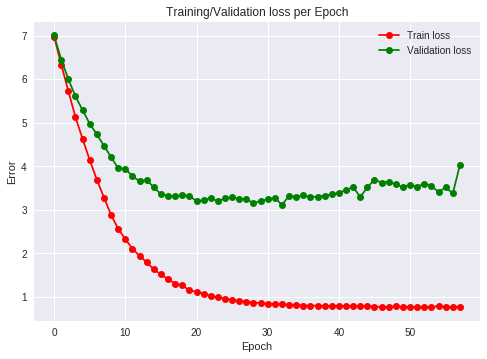

In [0]:
plot_info_path = root_folder+"plots/tf_language_model.csv"
plot_df = pd.read_csv(plot_info_path)
plot_df_per_epoch = plot_df.groupby(np.arange(len(plot_df))//50).mean()
train_error_per_epoch = plot_df_per_epoch['training_err']
validation_error_per_epoch = plot_df_per_epoch['validation_err']
print(len(plot_df))
f, ax = plt.subplots()
ax.plot(train_error_per_epoch, 'o-',c='r')
ax.plot(validation_error_per_epoch, 'o-',c='g')
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train loss', 'Validation loss'], loc = 0)
ax.set_title('Training/Validation loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Error') 
plt.plot()

#### (2.4.1) Generating New Titles

In [0]:
model_file = root_folder+"models/tf_language_model"

with tf.Session() as sess:
    model.saver.restore(sess, model_file)

    # Here are some headline starters.
    # They're all about tech companies, because
    # That is what is in our dataset
    headline_starters = ["bitcoin price", "today", "big"]
    
    for headline_starter in headline_starters:
        print("===================")
        print("Generating titles starting with: "+headline_starter)
        
        tokenized = tokenizer.word_tokenizer(headline_starter)
        current_build = [startI] + numerize_sequence(tokenized)

        while len(current_build) < input_length:
            current_padded = current_build[:input_length] + [padI] * (input_length - len(current_build))
            current_padded = np.array([current_padded])

            feed = {model.input_num: current_padded}
            logits = sess.run(model.output_logits, feed_dict=feed)

            last_index = len(current_build) - 1
            last_logits = logits[0][last_index]
            
            current_build.append(np.argmax(last_logits))
        
        produced_sentence = numerized2text(current_build)
        print(produced_sentence)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Paradigm/Paradigm (Spr 19) - Team 2/Colab-code/models/tf_language_model
Generating titles starting with: bitcoin price
<START> bitcoin price technical analysis for 03 / 15 / 2018 – longer-term downside targets drop for the rout in $ 8,000 ? crypto market cap in common ? $ 5922 month market cap gox and us gox maneuvers in 45 minutes minutes minutes lee lee lee lee levels crushed
Generating titles starting with: today
<START> today : bitcoin is crashing , but bottom still have in the world ' to be worth what it ? ! financial analyst ' in just an online threat to remake the island to this week in by storm , ’ below us $ 6000 , is ' off
Generating titles starting with: big
<START> big banks ban bitcoin purchases using credit cards - report for first time report - coindesk report - coindesk report ; s report ; s more than report illegal ac

#### (2.4.2) Fake/Unlikely News Headline Detection

Lower loss means the headline is more likely.

In [0]:
headline1 = "Bitcoin price crashes"
headline2 = "Bitcoin price reach a new high"
headline3 = "bitcoin is legal in all countries"

headlines = [headline1, headline2, headline3]

with tf.Session() as sess:
    model.saver.restore(sess, model_file)

    for headline in headlines:
        headline = headline.lower()

        tokenized = tokenizer.word_tokenizer(headline)
        numerized = numerize_sequence(tokenized)
        unkI, padI, startI = w2i['UNK'], w2i['PAD'], w2i['<START>']
        
        padded, mask = pad_sequence(numerized, padI, input_length)
        
        hl_element = {}
        hl_element['tokenized'] = tokenized
        hl_element['numerized'] = padded
        hl_element['mask'] = mask
        d_hl = [hl_element]
        hl_input, hl_target, hl_target_mask = build_batch(d_hl, 1)
        feed = {model.input_num: hl_input, model.targets: hl_target, model.targets_mask: hl_target_mask}
        loss = sess.run([model.loss], feed_dict=feed)
        print("----------------------------------------")
        print("Headline:",headline)
        print("Loss of the headline:", loss)

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Paradigm/Paradigm (Spr 19) - Team 2/Colab-code/models/tf_language_model
----------------------------------------
Headline: bitcoin price crashes
Loss of the headline: [6.74614]
----------------------------------------
Headline: bitcoin price reach a new high
Loss of the headline: [8.830537]
----------------------------------------
Headline: bitcoin is legal in all countries
Loss of the headline: [9.069546]
